# Inference of a gene regulatory network by applying OMOPSO to the S-System and half-system

The problem models are adapted from Khan et. al. doi: 10.1109/TCBB.2019.2892450 and Hurtado et. al. doi: 10.1007/s10489-020-01891-1

The optimization algorithm from Hurtado et. al. doi: 10.1007/s10489-020-01891-1

The python implementation of the jMetal framework from Benitez-Hidalgo et. al. is used: doi: 10.1016/j.swevo.2019.100598 - https://github.com/jMetal/jMetalPy

Experimental Gene Expression data can be downloaded here: http://wws.weizmann.ac.il/mcb/UriAlon/sites/mcb.UriAlon/files/uploads/DownloadableData/sosdata.zip



In [14]:
#import libraries
import numpy as np
import pandas as pd
import csv

from jmetal.algorithm.multiobjective.omopso import OMOPSO
from jmetal.operator import UniformMutation
from jmetal.operator.mutation import NonUniformMutation
from jmetal.util.archive import CrowdingDistanceArchive
from jmetal.util.termination_criterion import StoppingByEvaluations
from jmetal.core.problem import FloatProblem
from jmetal.core.solution import FloatSolution
from jmetal.lab.visualization.plotting import Plot
from jmetal.util.solution import get_non_dominated_solutions

import logging

logging.basicConfig(filename='AC_GRN_1.log', level=logging.DEBUG)

In [2]:
#test logging
'''
logging.debug('This message should go to the log file')
logging.info('So should this')
logging.warning('And this, too')
logging.error('And non-ASCII stuff, too, like Øresund and Malmö')
'''

"\nlogging.debug('This message should go to the log file')\nlogging.info('So should this')\nlogging.warning('And this, too')\nlogging.error('And non-ASCII stuff, too, like Øresund and Malmö')\n"

## Load and prepare experimental gene expression data

In [15]:
filepath = "./Data/SOSData/"
filenameActual = "SOSTopology.txt"

df_actualExpression = pd.read_csv(filepath + "Exp1.txt", sep='\t')

# omit first 2 columns of SOS dataset: 1.col = gene name; 2.col = first timepoint with only 0 values
df = df_actualExpression.iloc[:, 2:]
# normalize expression data to range (0,1)
norm_exp = df.apply(lambda x: (x-min(x))/(max(x)-min(x)), axis =1)
'''
NOTE on normalization:
Normalizing expression levels to a range of (0,1) flips the meaning of kinetic orders around:
num in range (0,1) to the power of a negative exponent => 1 < expression level < inf
num in range (0,1) to the power of a positive exponent => 0 < expression level < 1
'''


#Array for Problem Model: indexed by by time points (e.g. array[0] = vector of gene expression for timepoint 0 for all genes)
#convert df to np.array (no headers included) and convert all 0s to 1s (necessary for the problem model, otherwise there would be 0s in the sumprod setting the whole term to zero and throwing an error: NaN value)
actualExpressionTimeInd = np.transpose(norm_exp.to_numpy())
#actualExpressionTimeInd[actualExpressionTimeInd == 0] = 1

#Array for Fitness Caluculation: indexed by gene (e.g. array[0] = vector of gene expression of gene 0 for all timepoints) 
#convert df to np.array (no headers included)
actualExpressionGeneInd = norm_exp.to_numpy()


'''
#According to the author of the half-system paper, timepoints & deltas have not been normalized

# normalize timepoints to range(0,1)
def norm_array(arr):
    norm_arr = []
    min_arr = min(arr)
    max_arr = max(arr)
    for i in arr:
        temp = (i - min_arr)/(max_arr - min_arr)
        norm_arr.append(temp)
    return norm_arr

timepoints = norm_array(timepoints)
'''
# extract headers as np.array 
timepoints = np.array(df_actualExpression.columns[2:].astype(int))

# Define the Problem Models

## Half System Problem Model

Using the jMetal interface

Variable descriptions:

Solution / Variable: List(delta/rate constant, epsilon/degradation term, (error correction term), kinteic order f11 ... f1j, REPEAT for num of genes)

extra_vars = delta/rate constant, epsilon, (my)

=> error correction term/my has not been used


In [2]:
class GRNinfHS(FloatProblem):

    def __init__(self, number_of_genes, extra_vars, timepoints, actualExpressionGeneInd, actualExpressionTimeInd, constr):
        """ :param number_of_variables: Number of decision variables of the problem.
        """
        super(GRNinfHS, self).__init__()
        self.number_of_variables = (number_of_genes * number_of_genes) + extra_vars * number_of_genes
        self.number_of_objectives = 2
        self.number_of_constraints = 0

        self.number_of_genes = number_of_genes
        self.extra_vars = extra_vars

        self.obj_directions = [self.MINIMIZE, self.MINIMIZE]
        self.obj_labels = ['MSE', 'TR']

        # create np array with lower bound for variables
        df_lb = pd.DataFrame(np.zeros((self.number_of_genes,self.number_of_genes + self.extra_vars)))
        df_lb[0] = 0.
        df_lb[1] = 0.
        df_lb[df_lb.columns[self.extra_vars:]] = -3.
        lb = df_lb.to_numpy().ravel()
        
        self.lower_bound = lb #self.number_of_variables * [0.0]
        
        # create np array with upper bound for variables
        df_ub = pd.DataFrame(np.zeros((self.number_of_genes,self.number_of_genes + self.extra_vars)))
        df_ub[0] = 5.
        df_ub[1] = 5.
        df_ub[df_ub.columns[self.extra_vars:]] = 3.
        ub = df_ub.to_numpy().ravel()
        
        self.upper_bound = ub #self.number_of_variables * [1.0]

        self.timepoints = timepoints
        self.actualExpressionGeneInd = actualExpressionGeneInd
        self.actualExpressionTimeInd = actualExpressionTimeInd
        self.constr = constr

    #Caluclate Fitness
    def evaluate(self, solution: FloatSolution) -> FloatSolution:

        #transform solution variables from 1d list to 2d np.array. e.g. arr_solution[0] should give all variables for gene 0
        arr_solution = np.array(solution.variables)
        arr_solution.shape = (self.number_of_genes, -1)

        MSE = 0
        TR = 0

        for gene in range(0,self.number_of_genes):
            
            ts_pred = self.timeSeriesPrediction(arr_solution, gene)
            MSE = MSE + self.calculateMSE(ts_pred, gene)
            TR = TR + self.calculateTR(arr_solution, gene)

        #caluclate the mean over all genes
        MSE = MSE/self.number_of_genes

        solution.objectives[0] = MSE
        solution.objectives[1] = TR

        return solution



    #calculate predicted gene expression levels for one gene at all timepoints
    def timeSeriesPrediction(self, arr_solution, gene):

        #array to store time series gene expression predictions for one gene
        predExpression = np.empty(len(self.timepoints))
        predExpression[0] = 0

        #convert all 0s to 1s in the actual expression (necessary for the problem model, otherwise there would be 0s in the np.prod setting the whole term to zero and throwing an error: NaN value)
        actExpr = self.actualExpressionTimeInd
        actExpr[actExpr == 0] = 1

        for t in range(1,len(timepoints)):
            timediff = self.timepoints[t] - self.timepoints[t-1]
            #calculate predicted gene expression for one gene at one timepoint
            pred = timediff * (arr_solution[gene][0] * np.prod(np.power(actExpr[t-1], arr_solution[gene][self.extra_vars:]))) + (1 - timediff * arr_solution[gene][1]) * predExpression[t-1] 
            
            # Constraining predicted solution not to have <=0 values
            if self.constr:
                if pred <= 0:
                    predExpression[t] = 0
                else:
                    predExpression[t] = pred
            
            else:
                predExpression[t] = pred
            
            '''
            error correction term:
             + arr_solution[gene][2] * (predExpression[t-1] - self.actualExpressionTimeInd[gene][t-1])
            according to the author of the half-system paper, further research did not indicate that the error correction term provides any benefit and is omitted here as well
            ''' 
        return predExpression


    #calculate MSE for one gene for timeseries
    def calculateMSE(self, predExpression, gene):
        #version1
        MSE = sum(np.power(self.actualExpressionGeneInd[gene] - predExpression,2))/len(predExpression)
        
        #version2
        #MSE = sum(np.power((predExpression - self.actualExpressionGeneInd[gene])/self.actualExpressionGeneInd[gene], 2))
       
        return MSE


    #calculate TR for kinteic orders (not extra_vars: rate constant and degradation term) for one gene for timeseries
    def calculateTR(self, arr_solution, gene, cardinality = 4):
        sortedSol = np.sort(np.abs(arr_solution[gene][self.extra_vars:]))
        extract = sortedSol[:(self.number_of_genes-cardinality)]
        return sum(extract)

    def get_name(self):
        return 'GRNinfHS'

## S-System Problem Model

Using the jMetal interface

Variable descriptions:

Solution / Variable: List(alpha/rate constant production, alpha/rate constant degradation, kinteic order g11 ... g1j for production, kinteic order h11 ... h1j for degradation, REPEAT for num of genes)

extra_vars = delta/rate constant, epsilon, (my)

In [5]:
class GRNinfSS(FloatProblem):

    def __init__(self, number_of_genes, extra_vars, timepoints, actualExpressionGeneInd, actualExpressionTimeInd, constr, eta):
        """ :param number_of_variables: Number of decision variables of the problem.
        """
        super(GRNinfSS, self).__init__()
        self.number_of_variables = (2 * number_of_genes * number_of_genes) + extra_vars * number_of_genes
        self.number_of_objectives = 2
        self.number_of_constraints = 0

        self.number_of_genes = number_of_genes
        self.extra_vars = extra_vars

        self.obj_directions = [self.MINIMIZE, self.MINIMIZE]
        self.obj_labels = ['MSE', 'TR']

        # create np array with lower bound for variables
        df_lb = pd.DataFrame(np.zeros((self.number_of_genes,2*self.number_of_genes + self.extra_vars)))
        df_lb[0] = 0.
        df_lb[1] = 0.
        df_lb[df_lb.columns[self.extra_vars:]] = -3.
        lb = df_lb.to_numpy().ravel()
        
        self.lower_bound = lb #self.number_of_variables * [0.0]
        
        # create np array with upper bound for variables
        df_ub = pd.DataFrame(np.zeros((self.number_of_genes,2*self.number_of_genes + self.extra_vars)))
        df_ub[0] = 5.
        df_ub[1] = 5.
        df_ub[df_ub.columns[self.extra_vars:]] = 3.
        ub = df_ub.to_numpy().ravel()
        
        self.upper_bound = ub #self.number_of_variables * [1.0]

        self.timepoints = timepoints
        self.actualExpressionGeneInd = actualExpressionGeneInd
        self.actualExpressionTimeInd = actualExpressionTimeInd
        self.eta = eta
        self.constr = constr

    #Caluclate Fitness
    def evaluate(self, solution: FloatSolution) -> FloatSolution:
        #transform solution variables from 1d list to 2d np.array. e.g. arr_solution[0] should give all variables for gene 0
        arr_solution = np.array(solution.variables)
        arr_solution.shape = (self.number_of_genes, -1)

        #initialize ones array for preditcions
        predictions = np.ones(np.shape(self.actualExpressionTimeInd))

        #convert all 0s to 1s in the actual expression (necessary for the problem model, otherwise there would be 0s in the np.prod setting the whole term to zero and throwing an error: NaN value)
        actExpr = self.actualExpressionTimeInd
        actExpr[actExpr == 0] = 1

        # list to save index where constraint was set
        list_t_g = []

        # calculate prediced gene expression for all genes at timepoint t
        for t in range(1,len(timepoints)): 

            for gene in range(0,self.number_of_genes):
                pred = predictions[t-1][gene] + 0.5 * self.eta * (self.SScalc(actExpr, arr_solution, t, gene, "ACTUAL") + self.SScalc(predictions, arr_solution, t-1, gene, "PREDICTION"))
                
                if self.constr:
                    if pred <= 0:
                        predictions[t][gene] = 1
                        # save index to later set the predicted expression from 1 to 0 again
                        list_t_g.append((t,gene))
                    else:
                        predictions[t][gene] = pred
                else:
                    predictions[t][gene] = pred


                #logging.debug("Timepoint %s and gene %s", t, gene)
                #logging.debug(predictions[t][gene])

        # set predicted expression from 1 to 0 where constraint was applied; to have accurate MSE calculations
        for i in list_t_g:
            predictions[i] = 0

        # claculate MSE
        
        # version 1
        MSE = sum(sum(np.power(self.actualExpressionTimeInd - predictions,2)))/(len(actualExpressionTimeInd)*self.number_of_genes)

        # version 2
        #MSE = sum(sum(np.power((predictions - self.actualExpressionTimeInd)/self.actualExpressionTimeInd, 2)))

        # claculate TR
        TR = 0
        
        for gene in range(0,self.number_of_genes):
            sortedSol = np.sort(np.abs(arr_solution[gene][self.extra_vars:]))
            extract = sortedSol[:(self.number_of_genes*2-4)]
            TR = TR + sum(extract)

        solution.objectives[0] = MSE
        solution.objectives[1] = TR   

        return solution

    # calculate SS for one gene at one timepoint
    def SScalc(self, expression, arr_solution, t, gene, exptype):  
        result = arr_solution[gene][0] * np.prod(np.power(expression[t], arr_solution[gene][self.extra_vars : self.extra_vars + self.number_of_genes])) - arr_solution[gene][1] * np.prod(np.power(expression[t], arr_solution[gene][self.extra_vars + self.number_of_genes : ]))
        
        '''
        if exptype == "PREDICTION":
            logging.debug("Predicion SS result %s", result)
            logging.debug("Expression Array %s", expression[t])
            logging.debug("Solution Array Production %s", arr_solution[gene][self.extra_vars : self.extra_vars + self.number_of_genes]) 
            logging.debug("Solution Array Degradation %s", arr_solution[gene][self.extra_vars + self.number_of_genes : ])   
        if exptype == "ACTUAL":
            logging.debug("Actual SS result %s", result)   
        '''

        return result

    def get_name(self):
        return 'GRNinfSS'

## Functions to calculate performance measures

In [4]:
#Functions for calculating confusion matrix results

# solution / predicted data preparation for confusion matrix calcs
def prepareSolution(solutions, sol, prob = "SS"):
    solprep = np.array(solutions[sol].variables[:])
    solprep.shape = (8,-1)
    solprep = pd.DataFrame(solprep)
    # drop first 2 columns = extra variables
    solprep = solprep.drop(solprep.columns[[0,1]], axis =1)
    
    # calculations for SS Problem model

    if prob == "SS":
        splitcol = int(len(solprep.columns[:])/2) # needs logic to catch error when lenght of column number is odd
        sol_prod = solprep[solprep.columns[0:splitcol]]
        sol_degr = solprep[solprep.columns[splitcol:]]
        # substract degradation terms from production terms to get final kinetic order. 
        # Assumption: one gene can only decrease or increase the production of another gene, but not both
        solprep = (sol_prod.to_numpy() - sol_degr.to_numpy())
    else:
        solprep = solprep.to_numpy()

    # widen to 1d np array
    solprep = solprep.reshape(1,-1)
    solprep = solprep.ravel()
    
    '''
    Take the mean of the absolute values of the kinetic order
    Everything below the negative mean and above the positive mean is set to 1, indicating a valid interaction
    Everything else is set to 0, indicating no edge in the network
    '''
    abs_sols = np.absolute(solprep)
    mean_sols = abs_sols.mean()
    std_sols = abs_sols.std()

    '''
    solprep[solprep <= -mean_sols] = 1
    solprep[solprep >= mean_sols] = 1
    solprep[solprep != 1] = 0
    '''
    abs_sols[abs_sols >= mean_sols] = 1 # exchange mean_sols with arbitrary values for experimentation
    abs_sols[abs_sols != 1] = 0

    '''
    # replace all non-zero values with 1 (indicating that there is an edge between nodes)
    solprep[solprep != 0.] = 1
    solprep = solprep.astype(int)
    '''

    '''
    Set one variable to 0 to be able to caculate confusion matrix. Only necessary because algorithm doesnt succeed yet to set variables to 0.
    Otherwise there would not be a "non existing edge" in the gene network graph. All nodes would be connected.  
    The majority of variables should be zero => no existing edges
    '''
    #solprep[0] = 0
    
    
    #print(solprep)
    return abs_sols

# actual data preparation for confusion matrix calcs
def prepareActual(filepath, filename):
    # read in actual SOS topology
    actual = pd.read_csv(filepath + filename, sep='\t')
    # drop first column (gene names)
    actual = actual.iloc[: , 1:]
    # widen to 1d np array
    actual = actual.values.reshape(1,-1)
    actual = actual.ravel()

    # replace all non-zero values with 1 (indicating that there is an edge between nodes)
    actual[actual != 0] = 1
    
    #print(actual)
    return actual

# calculate confustion matrix results
def calculateConMatResults(solutions, solnum, filepath, filename, prob):
    predicted = prepareSolution(solutions, solnum, prob)
    actual = prepareActual(filepath, filename)

    Num_pred_edges = np.count_nonzero(predicted)

    # create df
    d = {"actual":actual, "predicted":predicted}
    df_confmat = pd.DataFrame(data=d)
    confmat = pd.crosstab(df_confmat['actual'], df_confmat['predicted'], rownames=['Actual'], colnames=['Predicted'])

    #print(df_confmat)
    #print(confmat)

    TP = confmat.iloc[1,1]
    FP = confmat.iloc[0,1]
    TN = confmat.iloc[0,0]
    FN = confmat.iloc[1,0]

    TPR = TP/(TP+FN)
    FPR = FP/(FP+TN)
    TNR = TN/(FP+TN)
    PPV = TP/(TP+FP)
    ACC = (TP+TN)/(TP+FP+FN+TN)
    Fscore = (2*TP)/(2*TP+FP+FN)

    d = {"TP":TP, "FP":FP, "TN":TN, "FN":FN, "TPR":TPR, "FPR":FPR, "TNR":TNR, "PPV":PPV, "ACC":ACC, "Fscore":Fscore, "Predicted Edges":Num_pred_edges}

    return d
    

# function to calculate the mean of a particular performance measure in the list of solution perpformances
def calcMean(lst_performance, key):
    avg = 0
    for sol in lst_performance:
        avg = avg + sol[key]

    return avg/len(lst_performance)

# function to calculate average performance of solutions
def calculateAverageResults(front, filepath, filenameActual, prob):
    
    # list to sore performance measures for each soltuion in the pareto front
    lst_performance = []
    # calculate performance for each solution and append to list
    for sol in range(0,len(front[:])):
        lst_performance.append(calculateConMatResults(front, sol, filepath, filenameActual, prob))

    # get dictionary keys from performance list
    lst_keys = list(lst_performance[0].keys())

    # calculate mean of all performance measures
    dict_avg_perf = {}

    for key in lst_keys:
        dict_avg_perf[key] = calcMean(lst_performance, key)

    return dict_avg_perf

# Execute the Optimization

Using the defined Problem Models with the jMetal OMOPSO algorithm

## Execute the S-System Opitmization

In [16]:
problem = GRNinfSS(number_of_genes = 8, extra_vars = 2, timepoints = timepoints, actualExpressionGeneInd = actualExpressionGeneInd, actualExpressionTimeInd = actualExpressionTimeInd, constr = True, eta = 0.000000000001) #, eta = 0.00000000001

max_evaluations = 10000
swarm_size = 100
mutation_probability = (swarm_size / 3) / 100

algorithm = OMOPSO(
    problem=problem,
    swarm_size=swarm_size,
    epsilon=0.0075,
    uniform_mutation=UniformMutation(probability=mutation_probability, perturbation=0.5),
    non_uniform_mutation=NonUniformMutation(mutation_probability, perturbation=0.5,
                                            max_iterations=int(max_evaluations / swarm_size)),
    leaders=CrowdingDistanceArchive(100),
    termination_criterion=StoppingByEvaluations(max_evaluations)
)

algorithm.run()
SS_solutions = algorithm.get_result()

C:\Users\thoma\anaconda3\envs\aci\lib\site-packages\numpy\core\fromnumeric.py:87: RuntimeWarning:

overflow encountered in reduce

<ipython-input-5-17676e6a5e2e>:104: RuntimeWarning:

overflow encountered in power

<ipython-input-5-17676e6a5e2e>:104: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\thoma\anaconda3\envs\aci\lib\site-packages\numpy\core\fromnumeric.py:87: RuntimeWarning:

invalid value encountered in reduce

<ipython-input-5-17676e6a5e2e>:84: RuntimeWarning:

overflow encountered in power

<ipython-input-5-17676e6a5e2e>:104: RuntimeWarning:

overflow encountered in double_scalars



## Visualize the Pareto Front

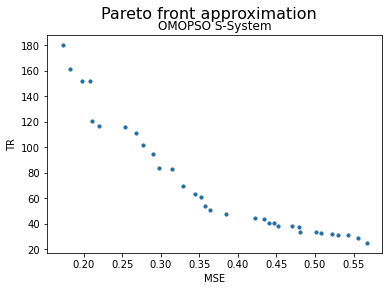

++++++
Objective Values
[0.5430960625643261, 30.790782479214208]
[0.5550886655033284, 29.108320879506827]
[0.46971317322443257, 38.24963333735099]
[0.47855124578039443, 37.79223513146914]
[0.5219081318179037, 31.91614021215026]
[0.2773426902514563, 101.33611246941204]
[0.48072107132417136, 33.824695426109464]
[0.35180440308320393, 60.906564490382834]
[0.2542305332528975, 115.94146335188385]
[0.3438163589408932, 63.44058348752788]
[0.31422015442466916, 83.2053654989383]
[0.19802042079528429, 152.04633348623472]
[0.44691860881005707, 40.43038384409293]
[0.44060811796772353, 40.65920170809363]
[0.5297053236061746, 31.086719003134725]
[0.4220639539716537, 44.15578191268889]
[0.20812986624865612, 151.63426620414623]
[0.5079269944070347, 32.528127965155704]
[0.43393016339286694, 43.446109641090366]
[0.35767725254948146, 53.56933566623812]
[0.21086505778144052, 120.27559100190356]
[0.5015818310113004, 33.25482427642028]
[0.38466732748383187, 47.321239332017235]
[0.18255751581640547, 161.59864

In [17]:
SS_front = get_non_dominated_solutions(SS_solutions)

plot_front = Plot(title='Pareto front approximation', axis_labels=['MSE', 'TR'])
plot_front.plot(SS_front, label='OMOPSO S-System')

#print fitness values of non-dominated solutions in the pareto front 
print("++++++")
print("Objective Values")

for sol in SS_front:
    print(sol.objectives)

## Calculating Average Performance over all solutions

Using confusion matrix metrics

In [18]:
calculateAverageResults(SS_front, filepath, filenameActual, prob = "SS")

{'TP': 4.545454545454546,
 'FP': 23.363636363636363,
 'TN': 31.636363636363637,
 'FN': 4.454545454545454,
 'TPR': 0.5050505050505051,
 'FPR': 0.42479338842975195,
 'TNR': 0.5752066115702481,
 'PPV': 0.16405085549956663,
 'ACC': 0.5653409090909091,
 'Fscore': 0.24728730232830173,
 'Predicted Edges': 27.90909090909091}

## Execute the Half-System Optimization

In [19]:
problem = GRNinfHS(number_of_genes = 8, extra_vars = 2, timepoints = timepoints, actualExpressionGeneInd = actualExpressionGeneInd, actualExpressionTimeInd = actualExpressionTimeInd, constr = False)

max_evaluations = 10000
swarm_size = 100
mutation_probability = (swarm_size / 3) / 100

algorithm = OMOPSO(
    problem=problem,
    swarm_size=swarm_size,
    epsilon=0.0075,
    uniform_mutation=UniformMutation(probability=mutation_probability, perturbation=0.5),
    non_uniform_mutation=NonUniformMutation(mutation_probability, perturbation=0.5,
                                            max_iterations=int(max_evaluations / swarm_size)),
    leaders=CrowdingDistanceArchive(100),
    termination_criterion=StoppingByEvaluations(max_evaluations)
)

algorithm.run()
HS_solutions = algorithm.get_result()

## Visualize the Pareto Front

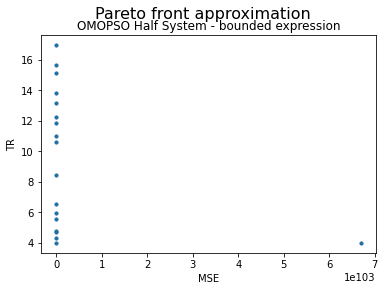

++++++
Objective Values
[8.21993374449172e+98, 4.003304295894305]
[1.0098403953742278e+89, 4.695895822602467]
[100136228805.51575, 6.532173563766361]
[1421967109.9790602, 11.869720475357836]
[6.515166229909488e+74, 4.758699287070191]
[280757418.4158001, 12.237968376772685]
[3669970526.0866647, 10.634083899933938]
[338342.0669738501, 15.143133363083813]
[3.352754518097198e+69, 5.52876967506121]
[84986.07806451811, 15.658971524692767]
[9900.07869246284, 16.95947812010496]
[1.7129214856551554e+21, 5.958354886016947]
[1.0274218432131038e+90, 4.300681917597504]
[37556438596.94335, 8.436538407445644]
[77264069.03781737, 13.171367036711054]
[3064213.908746111, 13.818207861877639]
[6.68593201122186e+103, 3.9804183568658904]
[1884612788.1058826, 11.004403128195166]


In [20]:
HS_front = get_non_dominated_solutions(HS_solutions)

plot_front = Plot(title='Pareto front approximation', axis_labels=['MSE', 'TR'])
plot_front.plot(HS_front, label='OMOPSO Half System - bounded expression')

#print fitness values of non-dominated solutions in the pareto front 
print("++++++")
print("Objective Values")

for sol in HS_front:
    print(sol.objectives)

## Calculating Average Performance over all solutions

Using confusion matrix metrics

In [21]:
calculateAverageResults(HS_front, filepath, filenameActual, prob = "HS")

{'TP': 2.8333333333333335,
 'FP': 22.333333333333332,
 'TN': 32.666666666666664,
 'FN': 6.166666666666667,
 'TPR': 0.3148148148148148,
 'FPR': 0.40606060606060596,
 'TNR': 0.5939393939393939,
 'PPV': 0.11194196033964748,
 'ACC': 0.5546875,
 'Fscore': 0.16472833216295885,
 'Predicted Edges': 25.166666666666668}